<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Model Tuning & Training</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">


</div>
<br>



In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import ray
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
import os 
import pickle
from sklearn.metrics import accuracy_score, classification_report, f1_score

try:
    import google.colab
    in_colab = True
    local_path = "/content/drive/MyDrive/DLSS/"
except ImportError:
    in_colab = False
    ## get current directory
    current_wd = os.getcwd()
    ## move one up to go to main directory
    local_path = os.path.dirname(current_wd)

print("CWD: ", local_path)


d:\dlss-project24\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-10 11:37:07,464	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-10 11:37:08,249	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


CWD:  d:\dlss-project24


In [2]:
import os

current_wd = os.getcwd()
parent_wd = os.path.dirname(current_wd)
parent_wd


'd:\\dlss-project24'

## Functions

In [117]:
# Function to create context-target pairs
def create_context_target_pairs_cbow(text, context_size):
    pairs = []
    for sentence in text:
        for i in range(context_size, len(sentence) - context_size):
            context = sentence[i - context_size:i] + sentence[i + 1:i + context_size + 1]
            target = sentence[i]
            pairs.append((context, target))
    return pairs

# Function to create context-target pairs for Skip-gram
def create_context_target_pairs_skipgram(text, context_size):
    pairs = []
    for sentence in text:
        for i in range(len(sentence)):
            target = sentence[i]
            context = sentence[max(0, i - context_size):i] + sentence[i + 1:i + context_size + 1]
            for ctx in context:
                pairs.append((target, ctx))
    return pairs

# Dataset and DataLoader definition
class Word2VecDataset_cbow(Dataset):
    def __init__(self, pairs, word_to_index):
        self.pairs = pairs
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        context, target = self.pairs[idx]
        context_idxs = torch.tensor([self.word_to_index[word] for word in context], dtype=torch.long)
        target_idx = torch.tensor(self.word_to_index[target], dtype=torch.long)
        return context_idxs, target_idx
  
class Word2VecDataset_skipgram(Dataset):
    def __init__(self, pairs, word_to_index):
        self.pairs = pairs
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        target, context = self.pairs[idx]
        target_idx = torch.tensor(self.word_to_index[target], dtype=torch.long)
        context_idx = torch.tensor(self.word_to_index[context], dtype=torch.long)
        return target_idx, context_idx  
    
class EarlyStopping:
    """
    Class that implements early stopping to halt training when the validation loss stops improving.

    Parameters:
    ----------
    patience : int
        Number of epochs to wait after the last improvement in validation loss before stopping the training.
    min_delta : float
        Minimum change in the validation loss to qualify as an improvement.

    Methods:
    ----------
    __call__(val_loss, model)
        Checks if the validation loss has improved and updates the state of early stopping.

    Attributes:
    ----------
    patience : int
        Number of epochs to wait after the last improvement in validation loss before stopping the training.
    min_delta : float
        Minimum change in the validation loss to qualify as an improvement.
    counter : int
        Counter for the number of epochs since the last improvement.
    best_loss : float or None
        Best recorded validation loss.
    early_stop : bool
        Indicating whether training should be stopped early.
    """

    def __init__(self, patience= int, min_delta= float):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, val_loss, model):
        ## for the first training iteration
        if self.best_loss is None:
            self.best_loss = val_loss
            ## check if the loss decreased, if not:
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            ## if loss decrease (more than the defined delta): save model parameters, reset counter and update best loss
        else:
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.counter = 0


def train_model_cbow(config, data):
    """
    Function that trains a model using the specified configuration and data, implements early stopping based on validation loss improvement, and reports training progress and results to Ray.

    Parameters:
    ----------
    config : dict
        Dictionary containing hyperparameters and settings for the model, training, and early stopping.
    data : tuple
        Tuple containing training and validation datasets.

    Returns:
    ----------
    dict
        A dictionary containing the final training loss, validation loss, accuracy, the epoch at which training stopped,
        and lists of validation and training losses across epochs.
    """
    
    
    filtered_corpus_train, filtered_corpus_val, word_to_index = data
    
    train_pairs = create_context_target_pairs_cbow(filtered_corpus_train, config["context_size"])
    val_pairs = create_context_target_pairs_cbow(filtered_corpus_val, config["context_size"])
    train_dataset = Word2VecDataset_cbow(train_pairs, word_to_index)
    val_dataset = Word2VecDataset_cbow(val_pairs, word_to_index)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, generator = torch.Generator().manual_seed(1234))
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    
    ## set seed to replicate the model
    torch.manual_seed(1234)

    ## empty lists to store loss
    train_losses = []
    val_losses = []

    ## initialise model
    model = CBOW(len(word_to_index), config["embedding_dim"]).to(device)
        
    ## loss criterion
    loss_criterion = nn.NLLLoss()

    ## choose optimiser
    optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    ## adapt learning rate with scheduler
    scheduler = StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

    #### Early Stopper ####
    early_stopper = EarlyStopping(patience= config["patience"], min_delta = config["min_delta"])

    #### Training ####
    ## each epoch iterates through the whole dataset
    for epoch in range(config["epochs"]):
        ## train model on training set
        model.train()
        ## set loss and r2 to zero again so we start fresh
        train_loss = 0
        ## iterate through batches of the training data (data is the features and target the target)
        for context_idxs, target_idx in train_loader:
            ## send tensors to gpu
            context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
            ## reset gradient to 0,start fresh again
            optimizer.zero_grad()
            ## predict target
            log_probs = model(context_idxs)
            ## caculate loss
            loss = loss_criterion(log_probs, target_idx)
            ## caculate gradients
            loss.backward()
            ## update weights
            optimizer.step()
            ## sum loss for all batches together
            train_loss += loss.item()
            
        train_losses.append(train_loss / len(train_loader))



        #### Validation ####
        ## check performance on validation set
        model.eval()
        ## set loss to zero again so we start fresh
        val_loss_sum = 0
        total = 0
        correct = 0

        ## as we test on the validation set, we do not want to update our weights now
        with torch.no_grad():
            for context_idxs, target_idx in val_loader:
                ## send tensors to gpu
                context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
                log_probs = model(context_idxs)
                ## caculate loss
                loss = loss_criterion(log_probs, target_idx)
                ## sum loss for whole epoch
                val_loss_sum += loss.item()
                
                # Get the index of the max log-probability
                _, predicted_idx = torch.max(log_probs, dim=1)
                correct += (predicted_idx == target_idx).sum().item()
                total += context_idxs.size(0)

        val_loss = val_loss_sum / len(val_loader)
        accuracy = correct / total
        val_losses.append(val_loss)

        ## adapt learning rate
        scheduler.step()

        ## save checkpoints only if loss decreased and the epoch is larger than the patience (to save less checkpoints) but always report metrics to ray
        if epoch > 0 and early_stopper.best_loss - config["min_delta"]  > val_loss:
          ##save checkpoint
          torch.save(model.state_dict(), "checkpoint_" + config["model"] + ".pt")

          ## report mertrics and save checkpoint
          ray.train.report(
                  {
                      "loss": round(early_stopper.best_loss, 2),
                      "val_loss_list": val_losses,
                      "train_loss_list": train_losses,
                      "accuracy": accuracy
                      },
                  checkpoint=Checkpoint.from_directory(".")
                  )
        else:
          ##report only metrics
          ray.train.report(
                  {
                      "loss": round(early_stopper.best_loss, 2), 
                      "val_loss_list": val_losses,
                      "train_loss_list": train_losses,
                      "accuracy": accuracy
                      }
                  )

        #### Early stopping ####
        # check if loss decreases more than defined threshold
        early_stopper(val_loss, model)

        if early_stopper.early_stop:
            break

    ## last checkpoint
    torch.save(model.state_dict(), "checkpoint_" + config["model"] + ".pt")
    ray.train.report(
        {"loss": round(early_stopper.best_loss, 3), "epoch": int(epoch), "accuracy": round(accuracy, 3)},
        checkpoint=Checkpoint.from_directory(".")
        )

    #return train_losses, val_losses, val_r2s
    return {
        "loss": round(early_stopper.best_loss, 2), 
        "accuracy": accuracy, 
        "val_loss_list": val_losses, 
        "train_loss_list": train_losses
        }

def train_model_skipgram(config, data):
    """
    Function that trains a model using the specified configuration and data, implements early stopping based on validation loss improvement, and reports training progress and results to Ray.

    Parameters:
    ----------
    config : dict
        Dictionary containing hyperparameters and settings for the model, training, and early stopping.
    data : tuple
        Tuple containing training and validation datasets.

    Returns:
    ----------
    dict
        A dictionary containing the final training loss, validation loss, accuracy, the epoch at which training stopped,
        and lists of validation and training losses across epochs.
    """
    
    
    filtered_corpus_train, filtered_corpus_val, word_to_index = data

    train_pairs = create_context_target_pairs_skipgram(filtered_corpus_train, config["context_size"])
    val_pairs = create_context_target_pairs_skipgram(filtered_corpus_val, config["context_size"])
    train_dataset = Word2VecDataset_skipgram(train_pairs, word_to_index)
    val_dataset = Word2VecDataset_skipgram(val_pairs, word_to_index)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, generator = torch.Generator().manual_seed(1234))
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    
    ## set seed to replicate the model
    torch.manual_seed(1234)

    ## empty lists to store loss
    train_losses = []
    val_losses = []

    ## initialise model
    model = SkipGram(len(word_to_index), config["embedding_dim"]).to(device)
        
    ## loss criterion
    loss_criterion = nn.NLLLoss()

    ## choose optimiser
    optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    ## adapt learning rate with scheduler
    scheduler = StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

    #### Early Stopper ####
    early_stopper = EarlyStopping(patience= config["patience"], min_delta = config["min_delta"])

    #### Training ####
    ## each epoch iterates through the whole dataset
    for epoch in range(config["epochs"]):
        ## train model on training set
        model.train()
        ## set loss and r2 to zero again so we start fresh
        train_loss = 0
        ## iterate through batches of the training data (data is the features and target the target)
        for context_idxs, target_idx in train_loader:
            ## send tensors to gpu
            context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
            ## reset gradient to 0,start fresh again
            optimizer.zero_grad()
            ## predict target
            log_probs = model(target_idx)
            ## caculate loss
            loss = loss_criterion(log_probs, context_idxs)
            ## caculate gradients
            loss.backward()
            ## update weights
            optimizer.step()
            ## sum loss for all batches together
            train_loss += loss.item()
            
        train_losses.append(train_loss / len(train_loader))



        #### Validation ####
        ## check performance on validation set
        model.eval()
        ## set loss to zero again so we start fresh
        val_loss_sum = 0
        total = 0
        correct = 0

        ## as we test on the validation set, we do not want to update our weights now
        with torch.no_grad():
            for context_idxs, target_idx in val_loader:
                ## send tensors to gpu
                context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
                log_probs = model(target_idx)
                ## caculate loss
                loss = loss_criterion(log_probs, context_idxs)
                ## sum loss for whole epoch
                val_loss_sum += loss.item()
                
                # Get the index of the max log-probability
                _, predicted_idx = torch.max(log_probs, dim=1)
                correct += (predicted_idx == context_idxs).sum().item()
                total += context_idxs.size(0)

        val_loss = val_loss_sum / len(val_loader)
        accuracy = correct / total
        val_losses.append(val_loss)

        ## adapt learning rate
        scheduler.step()

        ## save checkpoints only if loss decreased and the epoch is larger than the patience (to save less checkpoints) but always report metrics to ray
        if epoch > 0 and early_stopper.best_loss - config["min_delta"]  > val_loss:
          ##save checkpoint
          torch.save(model.state_dict(), "checkpoint_" + config["model"] + ".pt")

          ## report mertrics and save checkpoint
          ray.train.report(
                  {
                      "loss": round(early_stopper.best_loss, 2),
                      "val_loss_list": val_losses,
                      "train_loss_list": train_losses,
                      "accuracy": accuracy
                      },
                  checkpoint=Checkpoint.from_directory(".")
                  )
        else:
          ##report only metrics
          ray.train.report(
                  {
                      "loss": round(early_stopper.best_loss, 2), 
                      "val_loss_list": val_losses,
                      "train_loss_list": train_losses,
                      "accuracy": accuracy
                      }
                  )

        #### Early stopping ####
        # check if loss decreases more than defined threshold
        early_stopper(val_loss, model)

        if early_stopper.early_stop:
            break

    ## last checkpoint
    torch.save(model.state_dict(), "checkpoint_" + config["model"] + ".pt")
    ray.train.report(
        {"loss": round(early_stopper.best_loss, 3), "epoch": int(epoch), "accuracy": round(accuracy, 3)},
        checkpoint=Checkpoint.from_directory(".")
        )

    #return train_losses, val_losses, val_r2s
    return {
        "loss": round(early_stopper.best_loss, 2), 
        "accuracy": accuracy, 
        "val_loss_list": val_losses, 
        "train_loss_list": train_losses
        }



#### Tuning ####
## Custom function to shorten ray file path names
def short_dirname(trial) -> str:
    """
    Function that shortens path names created by Ray.

    Parameters:
    ----------
    trial : ray.tune.Trial
        The Ray trial object for which the directory name is being created.

    Return:
    ----------
    str
        A shortened file path in the format 'trial_<trial_id>'.
    """
    return "trial_" + str(trial.trial_id)


## actual tuning
def tune_parameters(training_function, num_samples, train_corpus, val_corpus, word_to_index, max_num_epochs, parameter_space, resources, local_path):
    """
    Function that tunes the hyperparameters for a DL model using ASHA scheduling and saves the best model and tuning results locally.

    Parameters:
    ----------
    training_function : function
        The function used for training the model during hyperparameter tuning.
    num_samples : int
        The number of hyperparameter samples to try.
    train_dataset : object
        Training dataset object.
    val_dataset : object
        Validation dataset object.
    max_num_epochs : int
        The maximum number of epochs for training each model.
    parameter_space : dict
        Dictionary defining the hyperparameter search space.
    resources : dict
        Resources configuration for training.
    local_path : str
        Local path to save tuning results and best model.

    Returns:
    ----------
    pandas.DataFrame
        DataFrame containing the tuning results, sorted by loss.
        """

    ## because min number of epochs in sampling range is 50
    #assert max_num_epochs > 50

    ## Hyperparameters to sample from
    ## ASHA scheduler to increase efficiency and stop inefficient training configs
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=3,
        reduction_factor=2
    )
    
    ## tuning function, choose resources
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(
                training_function,
                data = (train_corpus, val_corpus, word_to_index)),
                resources= resources
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
            trial_dirname_creator=short_dirname
        ),
        param_space= parameter_space,
        run_config = ray.train.RunConfig(storage_path = local_path, name="run_" + datetime.now().strftime("%m-%d_%H_%M"))
    )

    results = tuner.fit()


    #### Best Model ####
    ## get best model
    best_result = results.get_best_result("loss", "min")

    ## save info about best model
    with open(local_path + '/best_models/best_result_info_' + parameter_space["model"] + '.pkl', 'wb') as file:
        pickle.dump(best_result, file)

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(best_result.metrics["loss"]))

    ## get path to that best model
    best_checkpoint_path = best_result.get_best_checkpoint(metric = "loss", mode = "min").path + "/checkpoint_"+ parameter_space["model"] + ".pt"
    ## save path to model as txt
    with open(local_path + f"/best_models/path_best_model_" + parameter_space["model"] + ".txt", "w") as file:
        file.write(best_checkpoint_path)


    #### Tuning Overview ####
    ## Get results as df
    df_tuning_results = results.get_dataframe()
    ## Rename cols
    df_tuning_results.columns = [col.replace('config/', '') for col in df_tuning_results.columns]
    ## sort by loss
    df_tuning_results.sort_values("loss", inplace = True)
    ## Save only relevant cols
    df_tuning_results = df_tuning_results[['loss', "accuracy", "context_size", 'lr', 'batch_size', 'epochs',
                                           'patience', 'min_delta', "gamma", "step_size", 
                                           "dropout", 'time_total_s', "val_loss_list", "train_loss_list"]]
    ## Save as csv
    df_tuning_results.to_csv(local_path + "df_tuning_results.csv")

    return df_tuning_results


 #### Replication ####
def load_best_model(model_type = str, local_path = str):
    """
    Function that loads the best model based on the specified model type.

    Parameters:
    ----------
    model_type : str
        Type of the model to load ("CNN" or other).

    Return:
    ----------
    torch.nn.Module
        The best pre-trained model loaded on the device and ready for evaluation.
    """

    ## get best config
    with open(f'{local_path}/tuning_results/best_models/best_result_info_{model_type}.pkl', 'rb') as file:
    # Use pickle.dump() to write the data object to file
        best_result = pickle.load(file)

    with open(f"{local_path}/tuning_results/best_models/path_best_model_{model_type}.txt") as file:
        path_best_file = file.read()

    ## load parameters of best model
    best_checkpoint = torch.load(path_best_file)

    ## create new model
    if model_type == "CBOW":
        model_final = CBOW(
            vocab_size = len(word_to_index), 
            embedding_dim = best_result.metrics["config"]["embedding_dim"]
            )
    else:
        model_final = SkipGram(
            vocab_size = len(word_to_index), 
            embedding_dim = best_result.metrics["config"]["embedding_dim"]
            )
        
        

    ## load parameteres of best checkpoint
    model_final.load_state_dict(best_checkpoint)
    ## model into evaluation mode
    model_final.eval()
    model_final.to(device)

    return model_final


def plot_loss_curve(model_type = str, local_path = str):
    
   """
    Function that plots the training and validation loss curves of the best model.

    Parameters:
    ----------
    model_type : str
        Type of the model whose loss curve to plot ("CNN" or other).

    Return:
    ----------
    None
    """

   ## get file with loss data
   with open(local_path + f'/tuning_results/best_models/best_result_info_{model_type}.pkl', 'rb') as file:
       best_result = pickle.load(file)

   ## get respective tuning data
   val_losses = best_result.metrics["val_loss_list"]
   ## i forgot to divide the train loss by n in the training function
   ## and repeating that takes 8 hours, so I have to do it like this now
   train_losses = best_result.metrics["train_loss_list"]

   ## create plot
   plt.plot(train_losses, label='Training Loss')
   plt.plot(val_losses, label='Validation Loss')
   plt.title(f"{model_type} loss curves")
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.legend()
   ## save
   plt.savefig(local_path + f"plots/loss_curve_{model_type}.png")
   plt.show()


def classify(model_type, dataloader, index_to_word=index_to_word, include_true_vals=True):
    model = load_best_model(model_type, local_path=local_path)

    if model_type == "CBOW":
        with torch.no_grad():
            predictions, true_vals = [], []
            for context_idx, target_idx in dataloader:
                context_idx, target_idx = context_idx.to(device), target_idx.to(device)
                log_probs = model(context_idx)

                # Get the index of the max log-probability
                _, predicted_idx = torch.max(log_probs, dim=1)
                predictions.extend([index_to_word.get(word_id.item()) for word_id in predicted_idx.cpu().numpy()])
                
                if include_true_vals:
                    true_vals.extend([index_to_word.get(word_id.item()) for word_id in target_idx.cpu().numpy()])
    else:
        with torch.no_grad():
            predictions, true_vals = [], []
            for context_idx, target_idx in dataloader:
                context_idx, target_idx = context_idx.to(device), target_idx.to(device)
                log_probs = model(target_idx)

                # Get the index of the max log-probability
                _, predicted_idx = torch.max(log_probs, dim=1)
                predictions.extend([index_to_word.get(word_id.item()) for word_id in predicted_idx.cpu().numpy()])
                
                if include_true_vals:
                    true_vals.extend([index_to_word.get(word_id.item()) for word_id in context_idx.cpu().numpy()])

        
                
    if include_true_vals:
        return predictions, true_vals
    else:
        return predictions

# Function to evaluate the model
def evaluate_classification(model_type, prediction_val, prediction_test, y_val, y_test):
    """
    Function that evaluates a classification model by computing accuracy, recall, precision, and F-score for the training and validation data, and optionally for the test dataset.

    Parameters:
    ----------
    model_type : str
        Type of the model being evaluated.
    prediction_val : array
        Predictions made by the model on the validation dataset.
    prediction_test : array
        Predictions made by the model on the test dataset.
    y_val : array
        Actual target values in the validation dataset.
    y_test : array
        Actual target values in the test dataset.
    final_testing : bool, default=False
        Flag indicating whether to evaluate the model on the test dataset.

    Return:
    ----------
    None
    """
    print(f"\n--------------------------\n{model_type} Classification Evaluation \n--------------------------")


    print("\nValidation set")
    print("--------------")

    print(f"F1 Score: {f1_score(y_true = y_val, y_pred = prediction_val, average = 'micro'):.2f}")
    print(f"Accuracy: {accuracy_score(y_true = y_val, y_pred = prediction_val):.2f}")

    #print(classification_report(y_true = y_val, y_pred = prediction_val, digits=2, zero_division=0))
    print("\nTest set")
    print("--------\n")
    print(f"F1 Score: {f1_score(y_true = y_test, y_pred = prediction_test, average = 'micro'):.2f}")
    print(f"Accuracy: {accuracy_score(y_true = y_test, y_pred = prediction_test):.2f}")

    #print(classification_report(y_true = y_test, y_pred = prediction_test, digits=2, zero_division=0))

## Data Prep

In [ ]:
#### Parameters to choose:

## Exlude words with a count smaller than:
min_count = 6


In [3]:
## get data
comments = pd.read_csv(local_path +"data/preprocessed/comments.csv")

# Splitting the data into train, validation, and test sets
train_df, temp_df = train_test_split(comments, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

#Adding all comments for generating the vocabulary. If not an error occurs when tokens missing
total_comments_list = comments["lemmatized"].dropna().astype(str).tolist()

train_list = train_df["lemmatized"].dropna().astype(str).tolist()
val_list = val_df["lemmatized"].dropna().astype(str).tolist()
test_list = test_df["lemmatized"].dropna().astype(str).tolist()

# Ensure each entry is a string and split each sentence into words
total_corpus = [doc.split() for doc in total_comments_list]
corpus_train = [doc.split() for doc in train_list]
corpus_val = [doc.split() for doc in val_list]
corpus_test = [doc.split() for doc in test_list]

# Create a vocabulary: count occurrences of each word
vocab = defaultdict(int)
for sentence in total_corpus:
    for word in sentence:
        vocab[word] += 1

# Remove infrequent words from the vocabulary
vocab = {word: count for word, count in vocab.items() if count >= min_count}

# Create word to index and index to word mappings
word_to_index = {word: idx for idx, (word, _) in enumerate(vocab.items())}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Create DataFrame from vocabulary
vocab_df = pd.DataFrame(list(vocab.items()), columns=['Word', 'Count'])

vocab_set = set(vocab.keys())

def filter_corpus(corpus, vocab_set):
    return [[word for word in doc if word in vocab_set] for doc in corpus]

filtered_total_corpus = filter_corpus(total_corpus, vocab_set)
filtered_corpus_train = filter_corpus(corpus_train, vocab_set)
filtered_corpus_val = filter_corpus(corpus_val, vocab_set)
filtered_corpus_test = filter_corpus(corpus_test, vocab_set)


## Model Architecture

In [120]:
## use the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#### Continuous bag of words model #####
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        # Embedding layer for word indices
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Linear layer for mapping embeddings to vocab size
        self.linear1 = nn.Linear(embedding_dim, vocab_size)
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, context):
        # Get embeddings for context words
        embeds = self.embeddings(context)
        # Average embeddings to get a single vector
        combined = torch.mean(embeds, dim=1)
        # Apply dropout and pass through linear layer
        out = self.linear1(self.dropout(combined))
        # Compute log probabilities
        log_probs = torch.log_softmax(out, dim=1)
        return log_probs
    
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, target):
        embeds = self.embeddings(target)
        out = self.linear1(self.dropout(embeds))
        log_probs = torch.log_softmax(out, dim=1)
        return log_probs



cuda


## CBOW

In [6]:
#### Tuning ####
## choose sample size and max epoch
n_samples = 2
epochs = 10

In [123]:
## clear gpu memory
torch.cuda.empty_cache()

## tune
tune_parameters(
    train_model_cbow,
    num_samples=n_samples,
    train_corpus = filtered_corpus_train,
    val_corpus = filtered_corpus_val,
    word_to_index= word_to_index,
    max_num_epochs=epochs,
    resources = {"cpu": 2, "gpu": 1/2},
    parameter_space = {
            "model": "CBOW",
            "context_size": tune.choice([2, 3, 4, 5]),
            "dropout": tune.loguniform(0.1, 0.5),
            "lr": tune.loguniform(1e-4, 1e-2),
            "batch_size": tune.choice([32, 64, 128, 256, 512, 1024]),
            "epochs": tune.choice(list(range(50, 200, 10))),
            "patience": tune.choice([5, 10, 15]),
            "min_delta": tune.loguniform(0.01, 0.0001),
            "gamma": tune.choice([0.1, 0.25, 0.5, 0.75, 0.9]),
            "step_size": tune.choice([5, 10, 20]),
            "weight_decay": tune.loguniform(1e-4, 1e-2),
            "embedding_dim": tune.choice([50, 100, 250, 500, 750, 1000])
            },
    local_path = local_path + "/tuning_results"
    )


(train_model_cbow pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=d:/dlss-project24/tuning_results/run_08-10_11_07/trial_fc048_00000/checkpoint_000000)
(train_model_cbow pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=d:/dlss-project24/tuning_results/run_08-10_11_07/trial_fc048_00000/checkpoint_000001)
(train_model_cbow pid=5808) Checkpoint successfully created at: Checkpoint(filesystem=local, path=d:/dlss-project24/tuning_results/run_08-10_11_07/trial_fc048_00001/checkpoint_000000)
(train_model_cbow pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=d:/dlss-project24/tuning_results/run_08-10_11_07/trial_fc048_00000/checkpoint_000003) [repeated 2x across cluster]
(train_model_cbow pid=5808) Checkpoint successfully created at: Checkpoint(filesystem=local, path=d:/dlss-project24/tuning_results/run_08-10_11_07/trial_fc048_00001/checkpoint_000001)
(train_model_cbow pid=15232) Checkpoint successf

Best trial config: {'model': 'CBOW', 'context_size': 3, 'dropout': 0.1006225856471846, 'lr': 0.00047066208924158905, 'batch_size': 64, 'epochs': 160, 'patience': 15, 'min_delta': 0.0011307216364574318, 'gamma': 0.5, 'step_size': 20, 'weight_decay': 0.0013863074198250092, 'embedding_dim': 50}
Best trial final validation loss: 6.3


,loss,accuracy,context_size,lr,batch_size,epochs,patience,min_delta,gamma,step_size,dropout,time_total_s,val_loss_list,train_loss_list
1,6.30,0.062603,3,0.000471,64,160,15,0.001131,0.5,20,0.100623,125.294258,"[6.653580153197573, 6.433479100988622, 6.38542...","[7.317443246569703, 6.527974281679182, 6.41524..."
0,6.46,0.083219,3,0.000218,512,50,15,0.000285,0.9,10,0.102886,76.539425,"[7.50889457736099, 7.152932426385712, 6.883147...","[7.742914816912482, 7.312990130747066, 6.98739..."


### Loss Curve

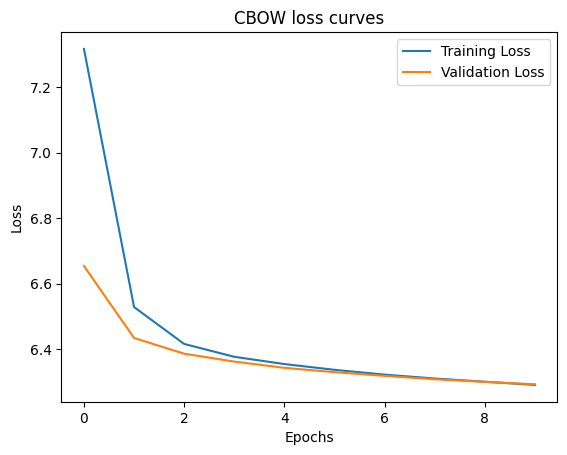

In [124]:
plot_loss_curve("CBOW", local_path = local_path)

### Accuracy & Loss

In [125]:
context_size = 2

val_pairs_cbow = create_context_target_pairs_cbow(filtered_corpus_val, context_size)
test_pairs_cbow = create_context_target_pairs_cbow(filtered_corpus_test, context_size)

val_dataset_cbow = Word2VecDataset_cbow(val_pairs_cbow, word_to_index)
test_dataset_cbow = Word2VecDataset_cbow(test_pairs_cbow, word_to_index)

val_loader_cbow = DataLoader(val_dataset_cbow, batch_size=len(val_dataset_cbow), shuffle=False)
test_loader_cbow = DataLoader(test_dataset_cbow, batch_size=len(test_loader_cbow), shuffle=False)

prediction_val_cbow, true_val_cbow = classify(model_type="CBOW", dataloader = val_loader_cbow, index_to_word=index_to_word)
prediction_test_cbow, true_test_cbow = classify(model_type="CBOW", dataloader = test_loader_cbow, index_to_word=index_to_word)

evaluate_classification(
    model_type = "CBOW", 
    prediction_val = prediction_val_cbow, 
    prediction_test = prediction_test_cbow, 
    y_val = true_val_cbow, 
    y_test = true_test_cbow
    )



--------------------------
CBOW Classification Evaluation 
--------------------------

Validation set
--------------
F1 Score: 0.07
Accuracy: 0.07

Test set
--------

F1 Score: 0.07
Accuracy: 0.07


## Skipgram

In [110]:
## clear gpu memory
torch.cuda.empty_cache()

## tune
tune_parameters(
    train_model_skipgram,
    num_samples=n_samples,
    train_corpus = filtered_corpus_train,
    val_corpus = filtered_corpus_val,
    word_to_index= word_to_index,
    max_num_epochs=epochs,
    resources = {"cpu": 2, "gpu": 1/2},
    parameter_space = {
            "model": "skipgram",
            "context_size": tune.choice([2, 3, 4, 5]),
            "dropout": tune.loguniform(0.1, 0.5),
            "lr": tune.loguniform(1e-4, 1e-2),
            "batch_size": tune.choice([32, 64, 128, 256, 512, 1024, 2048]),
            "epochs": tune.choice(list(range(50, 200, 10))),
            "patience": tune.choice([5, 10, 15]),
            "min_delta": tune.loguniform(0.01, 0.0001),
            "gamma": tune.choice([0.1, 0.25, 0.5, 0.75, 0.9]),
            "step_size": tune.choice([5, 10, 20]),
            "weight_decay": tune.loguniform(1e-4, 1e-2),
            "embedding_dim": tune.choice([50, 100, 250, 500, 750, 1000])
            },
    local_path = local_path + "/tuning_results"
    )


(train_model_skipgram pid=8680) Checkpoint successfully created at: Checkpoint(filesystem=local, path=d:/dlss-project24/tuning_results/run_08-10_10_48/trial_44ca2_00000/checkpoint_000000)
(train_model_skipgram pid=8680) Checkpoint successfully created at: Checkpoint(filesystem=local, path=d:/dlss-project24/tuning_results/run_08-10_10_48/trial_44ca2_00000/checkpoint_000001)
(train_model_skipgram pid=2692) Checkpoint successfully created at: Checkpoint(filesystem=local, path=d:/dlss-project24/tuning_results/run_08-10_10_48/trial_44ca2_00001/checkpoint_000000)
(train_model_skipgram pid=8680) Checkpoint successfully created at: Checkpoint(filesystem=local, path=d:/dlss-project24/tuning_results/run_08-10_10_48/trial_44ca2_00000/checkpoint_000002)
(train_model_skipgram pid=8680) Checkpoint successfully created at: Checkpoint(filesystem=local, path=d:/dlss-project24/tuning_results/run_08-10_10_48/trial_44ca2_00000/checkpoint_000003)
(train_model_skipgram pid=8680) Checkpoint successfully crea

Best trial config: {'model': 'skipgram', 'context_size': 5, 'dropout': 0.2356970652138274, 'lr': 0.00029262021765241074, 'batch_size': 2048, 'epochs': 190, 'patience': 15, 'min_delta': 0.00019123562055932368, 'gamma': 0.9, 'step_size': 10, 'weight_decay': 0.00035128996312930533, 'embedding_dim': 500}
Best trial final validation loss: 6.26


,loss,accuracy,context_size,lr,batch_size,epochs,patience,min_delta,gamma,step_size,dropout,time_total_s,val_loss_list,train_loss_list
0,6.26,0.054278,5,0.000293,2048,190,15,0.000191,0.90,10,0.235697,752.334421,"[6.9580595769038815, 6.700739176094937, 6.5639...","[7.394197521209716, 6.850115529469082, 6.63714..."
1,6.61,0.052090,5,0.000870,256,170,15,0.002667,0.25,20,0.343503,784.700439,"[6.665025291897775, 6.605332829070863, 6.60791...","[6.820661433574706, 6.623316493411642, 6.60759..."


### Loss Curve


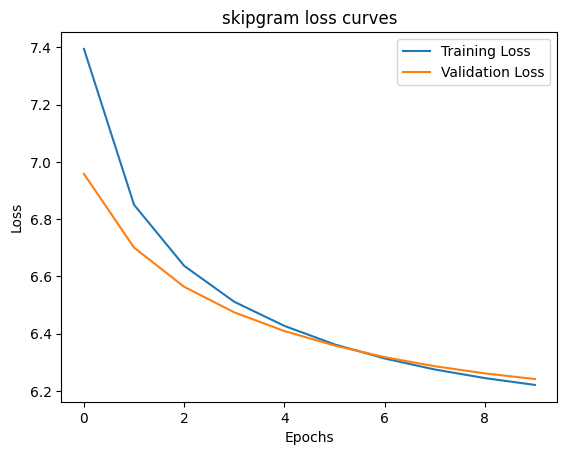

In [111]:
plot_loss_curve("skipgram", local_path = local_path)

### Accuracy & Loss

In [118]:
context_size = 2

val_pairs_skipgram = create_context_target_pairs_skipgram(filtered_corpus_val, context_size)
test_pairs_skipgram = create_context_target_pairs_skipgram(filtered_corpus_test, context_size)

val_dataset_skipgram = Word2VecDataset_skipgram(val_pairs_skipgram, word_to_index)
test_dataset_skipgram = Word2VecDataset_skipgram(test_pairs_skipgram, word_to_index)

val_loader_skipgram = DataLoader(val_dataset_skipgram, batch_size=len(val_dataset_cbow), shuffle=False)
test_loader_skipgram = DataLoader(test_dataset_skipgram, batch_size=len(test_loader_cbow), shuffle=False)

prediction_val_skipgram, true_val_skipgram = classify(model_type="skipgram", dataloader = val_loader_skipgram, index_to_word=index_to_word)
prediction_test_skipgram, true_test_skipgram = classify(model_type="skipgram", dataloader = test_loader_skipgram, index_to_word=index_to_word)

evaluate_classification(
    model_type = "skipgram", 
    prediction_val = prediction_val_skipgram, 
    prediction_test = prediction_test_skipgram,
    y_val = true_val_skipgram, 
    y_test = true_test_skipgram
    )



--------------------------
skipgram Classification Evaluation 
--------------------------

Validation set
--------------
F1 Score: 0.06
Accuracy: 0.06

Test set
--------

F1 Score: 0.07
Accuracy: 0.07
